<a href="https://colab.research.google.com/github/mauricioyc/Probabilistic-Machine-Learning/blob/master/Markov_Chain_Monte_Carlo/Markov_Chain_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem: 
Given a probabilistic distribution function $p(x)$, we want to sample from it. Considering that the distribution is not easy to invert the cdf ($P^{-1}(x)$) to use simple sample methods such as rejection sample by transforming a uniform distribution $U(0,1)$.




# Solution (Naive): Metropolis Hastings Sampling
The ideia is to use a known distribution, such as a normal $q(\tilde{x}) \text{~} (\mu,\sigma)$ and sample $\tilde{x} \text{~} q(\tilde{x}|x_t)$. Then a Markov Chain Monte Carlo is applied.

# Simulation
* initiate $x_t = x_0 = \mu$ 
* draw $\tilde{x} \text{~} q(\tilde{x}|x_t)$
* evaluate $a = \dfrac{\hat{p}(\tilde{x})q(x_t|\tilde{x})}{\hat{p}(x_t)q(\tilde{x}|x_t)}$
* if $a > 1$:
  * update $x_{t+1} = \tilde{x}$
* else:
  * with probability p update $x_{t+1} = \tilde{x}$
  * with probability 1- p update $x_{t+1} = x_t$

It is importante to consider that the initial samples maybe more innacurate, given that the prior is mode distant than the posterior. For that, it is recommended to ignore the first ocurrences before sampling.

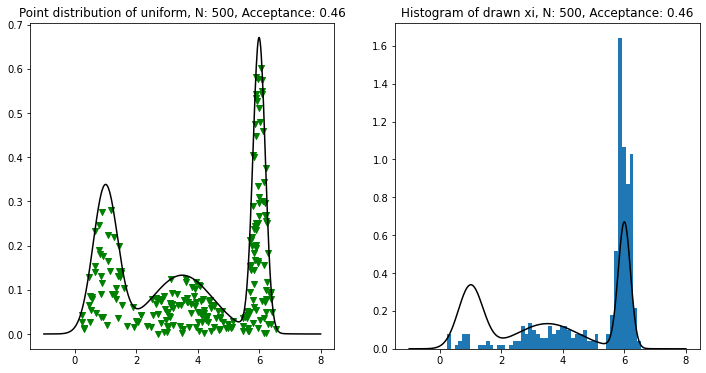

In [1]:
import numpy as np
from numpy.random import uniform
from scipy import stats, integrate
import matplotlib.pyplot as plt

def MH_MCMC(mean, sigma, target_function, N_ITER, ignore_first):
  # defining the q(x)
  def qx(x, m, o):
    return stats.norm.pdf(x, loc=m, scale=o)

  x_t = [] # initialization of samples
  xa, points = [], [] # initialization of accepted samples
  acceptance = 0 # acceptance rate of algorithm

  for i in range(N_ITER):
    x_t.append(mean)
    x_tilda = stats.norm.rvs(loc = x_t[i], scale = sigma)

    px_t = target_function(x_t[i])
    px_tilda = target_function(x_tilda)

    # not necessary, given that will cancel in the method
    qx_t = qx(x_t[i], x_tilda, sigma)
    qx_tilda = qx(x_tilda, x_t[i], sigma)

    a = (px_tilda*qx_t)/(px_t*qx_tilda)
    p = min(a, 1)
    u = uniform(0 , 1)

    if u < a: 
      mean = x_tilda
      points.append(uniform(0,px_t))   
      xa.append(x_t[i])
      acceptance = acceptance + 1

  acceptance = acceptance/N_ITER
  return x_t[int(0.2*N_ITER):], xa, points, acceptance

# Main Variables
N_ITER = 500 # samples
space = np.linspace(-1, 8, N_ITER) # linear space for function definition and plot

# defining target function
def gauss(x, m, o):
  return(1/(np.sqrt(2*np.pi)*o)*np.exp(-0.5*((x-m)/o)**2))

def px(x, c=1):
  p = gauss(x, 1, 0.4)
  p = p + gauss(x, 3.5, 1)
  p = p + gauss(x, 6, 0.2)
  p = p/c
  return p
c = integrate.simps(px(space,1), x=space, even='avg') # normalization factor due to the way the px(x) was contructed
target_function = lambda x: px(x, c=c) # target function


# q(x) variables
mean = 3 # starting with qx = gauss(x, 3, 1)
sigma = 1 # starting with qx = gauss(x, 3, 1)
ignore_first = 0.2 # % of samples to ignore


# Metropolis Hastings - Markov Chain Monte Carlo
samples, samples_accepted, points, acceptance = MH_MCMC(mean, sigma, target_function, N_ITER, ignore_first)

# Plotting Results
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 6))

ax0.set_title('Point distribution of uniform, N: {}, Acceptance: {}'.format(N_ITER, acceptance))
ax0.plot(space, target_function(space), c='black');
ax0.scatter(samples_accepted, points, c='green', marker='v');

ax1.set_title('Histogram of drawn xi, N: {}, Acceptance: {}'.format(N_ITER, acceptance))
ax1.plot(space, px(space, c), c='black');
ax1.hist(samples, bins=50, density=True);


Demonstrate later:
* sigma may increase or decrease the acceptance, but with smaller/higher steps
* the mean moves in a given diretion the optimization
* expected distance traveled by a random walk (convergence at sqrt of # of samples)


# Solution (Naive): Gibbs
https://github.com/mr-easy/Gibbs-Sampling-Visualized/blob/master/Gibbs_from_2d_normal.ipynb

# Con: axes should be aligned to take optimun steps

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from random import random

try:
  import gif
except:
  !pip install gif
  import gif

def plot_gaussian_from_points(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data.")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_gaussian_from_parameters(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
	mean : array-like, shape (2, )
    	Mean vector
    cov : array-like, shape (2,2)
    	Covariance matrix
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(mean) != 2:
        raise ValueError("Mean vector length should be 2.")
    if (cov.shape != (2, 2)):
    	raise ValueError("Covariance should be a 2x2 matrix.")
    #checking if cov is symmetric pos semidefinite
    if(cov[0, 1] != cov[1, 0]):
        raise ValueError("Covariance should be symmetric.")
    if(cov[0, 0] < 0 or cov[0, 0]*cov[1,1] - cov[0,1]**2 < 0):
        raise ValueError("Covariance should be positive semidefinite.")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [3]:
def conditional_sampler(sampling_index, current_x, mean, cov):
    conditioned_index = 1 - sampling_index
    a = cov[sampling_index, sampling_index]
    b = cov[sampling_index, conditioned_index]
    c = cov[conditioned_index, conditioned_index]
    
    mu = mean[sampling_index] + (b * (current_x[conditioned_index] - mean[conditioned_index]))/c
    sigma = np.sqrt(a-(b**2)/c)
    new_x = np.copy(current_x)
    new_x[sampling_index] = np.random.randn()*sigma + mu
    return new_x

In [4]:
@gif.frame
def plot_samples(samples, num_samples, tmp_points, num_tmp, title="Gibbs Sampling", xlims=(-11, 11), ylims=(-11, 11)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    
    # Plot the true distribution
    plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', alpha=0.5, label="True Distribution")
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    ax.scatter(samples[0, 0], samples[0, 1], marker='*', c='g', s=60, label="Initial Point")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFS
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], 
                [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
        # Plot estimated Gaussian, ignoring the starting point
        if(num_samples > 2):
            plot_gaussian_from_points(samples[1:num_samples, 0], samples[1:num_samples, 1], 
                                      ax, n_std=2, edgecolor='b', alpha=0.5, label="Estimated Distribution")
    
    ax.legend(loc='upper left')
    ax.set_title(title)

In [5]:
def gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True):

    frames = []  # for GIF
    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2])  #sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples, 2]) #inbetween points

    for i in range(num_samples):

        # Sample from p(x_0|x_1)
        point = conditional_sampler(0, point, mean, cov)
        tmp_points[i] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+1, tmp_points, i+1, title="Num Samples: " + str(i)))
            
        # Sample from p(x_1|x_0)
        point = conditional_sampler(1, point, mean, cov)
        samples[i+1] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+2, tmp_points, i+1, title="Num Samples: " + str(i+1)))
            
    if(create_gif):
        return samples, tmp_points, frames
    else:
        return samples, tmp_points

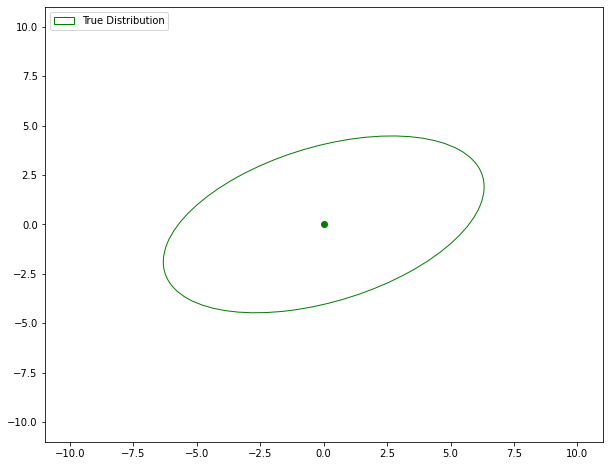

In [37]:
mean = np.array([0, 0])
cov = np.array([[10, 3], 
                [3, 5]])


# Plot true distribution
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', label="True Distribution")
ax.scatter(mean[0], mean[1], c='g')
ax.set_xlim((-11, 11))
ax.set_ylim((-11, 11))
ax.legend(loc='upper left')
plt.show()

In [38]:
initial_point = [-9.0, -9.0]
num_samples = 500
samples, tmp_points, frames = gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True)

In [ ]:
# Creating the GIF
gif.save(frames, "gibbs.gif", duration=150)

In [83]:
%matplotlib inline

with open('gibbs.gif','rb') as f:
    Image(data=f.read(), format='png')

# Solution: Hamiltonian

https://towardsdatascience.com/python-hamiltonian-monte-carlo-from-scratch-955dba96a42d

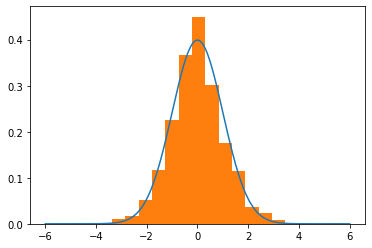

In [79]:
import numpy as np
import random
import scipy.stats as st
import matplotlib.pyplot as plt

def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma))

def HMC(mu=0.0,sigma=1.0,path_len=1,step_size=0.25,initial_position=0.0,epochs=1_000):
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    samples = [initial_position]
    momentum_dist = st.norm(0, 1) 
    # generate samples
    for e in range(epochs):
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs()        
        p1 = np.copy(p0) 
        dVdQ = -1*(q0-mu)/(sigma**2) # gradient of PDF wrt position (q0) aka potential energy wrt position

        # leapfrog integration begin
        for s in range(steps): 
            p1 += step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
            q1 += step_size*p1 # position increases as function of momentum 
            p1 += step_size*dVdQ/2 # second half-step "leapfrog" update to momentum    
        # leapfrog integration end        
        p1 = -1*p1 #flip momentum for reversibility     

        
        #metropolis acceptance
        q0_nlp = neg_log_prob(x=q0,mu=mu,sigma=sigma)
        q1_nlp = neg_log_prob(x=q1,mu=mu,sigma=sigma)        

        p0_nlp = neg_log_prob(x=p0,mu=0,sigma=1)
        p1_nlp = neg_log_prob(x=p1,mu=0,sigma=1)
        
        # Account for negatives AND log(probabiltiies)...
        target = q0_nlp - q1_nlp # P(q1)/P(q0)
        adjustment = p1_nlp - p0_nlp # P(p1)/P(p0)
        acceptance = target + adjustment 
        
        event = np.log(random.uniform(0,1))
        if event <= acceptance:
            samples.append(q1)
        else:
            samples.append(q0)
    
    return samples
        
import matplotlib.pyplot as plt
mu = 0
sigma = 1
trial = HMC(mu=mu,sigma=sigma,path_len=1.5,step_size=0.25)

lines = np.linspace(-6,6,10_000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

plt.plot(lines,normal_curve);
plt.hist(trial,density=True,bins=20);
plt.show();